# Your First AI application

In this project, I have trained an image classifier to recognize different species of flowers.  I used [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

I now have an application that can be trained on any set of labeled images. Here the network will be learning about flowers and end up as a command line application. 

## Import Resources

In [ ]:
## NOTE: This cell may need to be run when using the GPU
# !pip install grpcio
# !pip install tensorflow --upgrade --user

In [1]:
# # The new version of dataset is only available in the tfds-nightly package.
# %pip --no-cache-dir install tensorflow-datasets --user
# # DON'T MISS TO RESTART THE KERNEL

# The new version of dataset is only available in the tfds-nightly package.
%pip --no-cache-dir install tfds-nightly --user
# DON'T MISS TO RESTART THE KERNEL

Note: you may need to restart the kernel to use updated packages.


In [67]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub


# Make all other necessary imports.
import numpy as np
import matplotlib.pyplot as plt
import json
from tensorflow.keras import layers
import time
import glob
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
%matplotlib inline


print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)

Using:
	• TensorFlow version: 2.5.0
	• tf.keras version: 2.5.0


## Load the Dataset

Here I have used `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  I have also normalised the training data and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but I have still normalized and resized the images to the appropriate size.

In [3]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
data, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

# Create a training set, a validation set and a test set.
training_set, validation_set, test_set = data['train'],data['validation'],data['test']

2021-08-05 18:37:10.559775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-05 18:37:10.559829: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
usage: download_and_prepare.py build [-h] [--helpfull]
                                     [--module_import MODULE_IMPORT]
                                     [--builder_config_id BUILDER_CONFIG_ID]
                                     [--datasets DATASETS_KEYWORD [DATASETS_KEYWORD ...]]
                                     [--overwrite]
                                     [--max_examples_per_split [MAX_EXAMPLES_PER_SPLIT]]
                                     [--data_dir DATA_DIR]
                                     [--download_dir DOWNLOAD_DIR]
                                     [--extract_dir EXT

## Explore the Dataset

In [5]:
# Get the number of examples in each set from the dataset info.
print("The number of images in the training set is: ", dataset_info.splits['train'].num_examples)
print("The number of images in the validation set is: ", dataset_info.splits['validation'].num_examples)
print("The number of images in the test set is: ", dataset_info.splits['test'].num_examples)

The number of images in the training set is:  1020
The number of images in the validation set is:  1020
The number of images in the test set is:  6149


In [6]:
# Get the number of classes in the dataset from the dataset info.
print("The number of flower types in the whole sample is: ", dataset_info.features['label'].num_classes)


The number of flower types in the whole sample is:  102


In [7]:
# Print the shape and corresponding label of 3 images in the training set.
i = 1
for image, label in training_set.take(3):
    print("This image ({}) has " .format(i))
    print("shape: ", image.shape)
    print("Label: ", label.numpy())
    i+=1



This image (1) has 
shape:  (500, 667, 3)
Label:  72
This image (2) has 
shape:  (500, 666, 3)
Label:  84
This image (3) has 
shape:  (670, 500, 3)
Label:  70


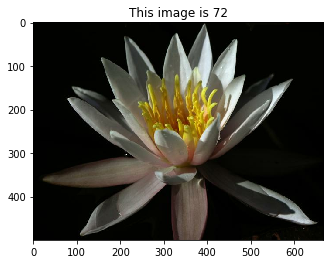

In [8]:
# Plot 1 image from the training set. 
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)

# Set the title of the plot to the corresponding image label. 
plt.title('This image is {}'.format(label))
plt.show()

### Label Mapping

I have also loaded in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [9]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [10]:
class_names

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

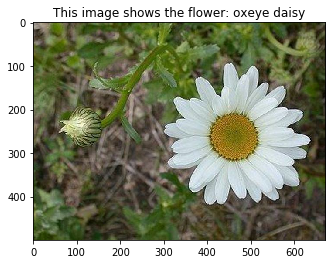

In [11]:
# Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for image, label in training_set.take(5):
    image = image.numpy()
    label = label.numpy()
    val = str(label + 1) 


plt.imshow(image)

# Set the title of the plot to the corresponding image label. 
plt.title('This image shows the flower: {}'.format(class_names.get(val)))
plt.show()


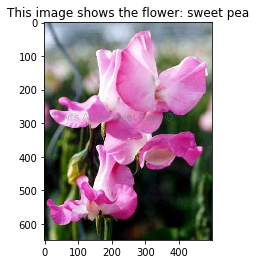

In [12]:
# Plot another to sanity check the labels

for image, label in training_set.take(65):
    image = image.numpy()
    label = label.numpy()
    val = str(label + 1) 


plt.imshow(image)

# Set the title of the plot to the corresponding image label. 
plt.title('This image shows the flower: {}'.format(class_names.get(val)))
plt.show()

## Create Pipeline

In [13]:
# Create a pipeline for each set.
BATCH_SIZE = 32
IMG_SHAPE  = 224

train_n = dataset_info.splits['train'].num_examples

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
    image /= 255
    return image, label

training_batches = training_set.shuffle(train_n//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
testing_batches = test_set.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [ ]:
# Experiment with shuffle - currently it takes a random sample of 255 images to shuffle, 
# but we can increase or decrease this depending on how much time we want to use to train our model

# Batch size is the number of images we pass to our neural network with each iteration. Again, this is for efficiency

# map transformation - 

# prefetch - prepares next batch of data while previous batch is being processed, again for efficiency.

# Order is important e.g. map has an overhead of 1 minute, if you call it on each image it will take one minute per image
# plus the time that it takes to perform the function. If you call batch prior to map, you can apply the function to
# 64 (or batch size) images with only 1 minute of overhead from map, so this is more efficient. 

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. I used the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

Steps taken:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 


In [15]:
# Download the MobileNet pre-trained model, this will form the first layer of a sequential model
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE,3))

# Freeze the weights and bias of the pre-trained model so that we do not modify them
feature_extractor.trainable = False

In [16]:
# Create a sequential model, the first layer being mobilenet
# 102 labels in the dataset (above)
model = tf.keras.Sequential([
    feature_extractor, # first layer
    tf.keras.layers.Dense(102, activation ='softmax') # output layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
# Compile the model
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# Print accuracy and loss before training the model
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)
    
print("Loss before training: {:,.3f}" .format(loss))
print("Accuracy before training: {:,.3%}" .format(accuracy))

1/1 [==============================] - 2s 2s/step - loss: 4.8188 - accuracy: 0.0000e+00
Loss before training: 4.819
Accuracy before training: 0.000%


In [18]:
# Train the model
EPOCHS = 40
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(training_batches,
                    epochs = EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/40
32/32 [==============================] - 44s 1s/step - loss: 4.3056 - accuracy: 0.1216 - val_loss: 3.0923 - val_accuracy: 0.3824
Epoch 2/40
32/32 [==============================] - 40s 1s/step - loss: 2.0922 - accuracy: 0.6922 - val_loss: 2.0111 - val_accuracy: 0.6461
Epoch 3/40
32/32 [==============================] - 40s 1s/step - loss: 1.1181 - accuracy: 0.9049 - val_loss: 1.5355 - val_accuracy: 0.7343
Epoch 4/40
32/32 [==============================] - 40s 1s/step - loss: 0.6761 - accuracy: 0.9549 - val_loss: 1.2936 - val_accuracy: 0.7637
Epoch 5/40
32/32 [==============================] - 41s 1s/step - loss: 0.4512 - accuracy: 0.9833 - val_loss: 1.1536 - val_accuracy: 0.7814
Epoch 6/40
32/32 [==============================] - 40s 1s/step - loss: 0.3182 - accuracy: 0.9931 - val_loss: 1.0644 - val_accuracy: 0.7922
Epoch 7/40
32/32 [==============================] - 41s 1s/step - loss: 0.2378 - accuracy: 0.9980 - val_loss: 1.0004 - val_accuracy: 0.8020
Epoch 8/40
32/32 [==

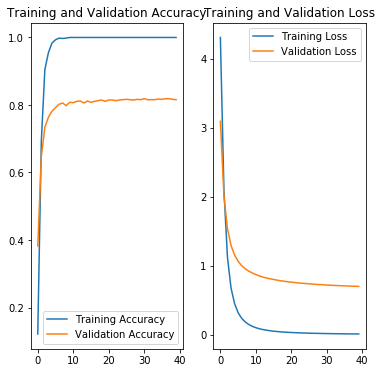

In [22]:
# Plot the loss and accuracy values achieved during training for the training and validation set.

training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# Print accuracy and loss after training the model

for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)
    
print("Loss after training: {:,.3f}" .format(loss))
print("Accuracy after training: {:,.3%}" .format(accuracy))



1/1 [==============================] - 1s 676ms/step - loss: 0.0090 - accuracy: 1.0000
Loss after training: 0.009
Accuracy after training: 100.000%


## Testing your Network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [24]:
# Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model.evaluate(testing_batches)
print("Loss on training set: {:,.3f}" .format(loss))
print("Accuracy on training set: {:,.3%}" .format(accuracy))


193/193 [==============================] - 119s 617ms/step - loss: 0.8387 - accuracy: 0.7853
Loss on training set: 0.839
Accuracy on training set: 78.533%


## Save the Model

Now that the network is trained, I have saved the model to load it later for making inference. In the cell below I have saved my model as a Keras model (*i.e.* save it as an HDF5 file).

In [30]:
# Save trained model as a Keras model.
t = time.time()

saved_keras_model_filepath = './{}.h5'.format(int(t))
print('saved_keras_model_filepath: ',saved_keras_model_filepath)
model.save(saved_keras_model_filepath, overwrite=False)

!ls

saved_keras_model_filepath:  ./1628191507.h5
1627854133.h5  1628190528.h5  label_map.json
1628185489.h5  1628191507.h5  Project_Image_Classifier_Project.ipynb
1628185576.h5  assets	      test_images


## Load the Keras Model

Load the Keras model you saved above.

In [31]:
# Load the Keras model
reloaded_keras_model = tf.keras.models.load_model('./1628191507.h5', custom_objects={'KerasLayer': hub.KerasLayer})

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
# Check it is the same model
for image_batch, label_batch in testing_batches.take(1):
    prediction1 = model.predict(image_batch)
    prediction2 = reloaded_keras_model.predict(image_batch)
    difference = np.abs(prediction1 - prediction2)
    print(difference.max())

0.0


# Inference for Classification

Here I have written a function that uses the trained network for inference. A function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert the image back to a NumPy array using the `.numpy()` method.

In [40]:
# Create the process_image function
def process_image(image_array):
    image_tensor = tf.convert_to_tensor(image_array)
    image_resized = tf.image.resize(image_tensor, [IMG_SHAPE, IMG_SHAPE])
    image_resized /= 255
    image_final = image_resized.numpy()
    return image_final


To check the `process_image` function I have been provided with 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by the `process_image` function. If the `process_image` function works, the plotted image should be the correct size. 

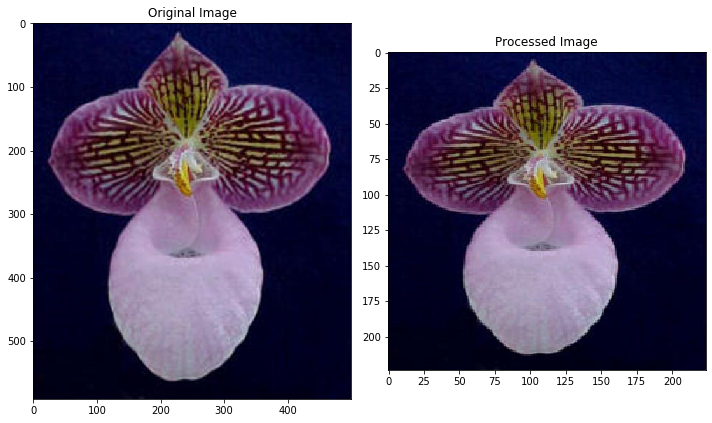

In [41]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once the images are in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [113]:
# Create the predict function
def predict(image_path, model, top_k):
    im = Image.open(image_path)
    test_image = np.asarray(im)
    test_image_proc = process_image(test_image)
    expand_image = np.expand_dims(test_image_proc, axis=0)
    img_prediction = model.predict(expand_image)

    probs, classes = tf.math.top_k(img_prediction,top_k)
    probs = probs.numpy().squeeze()
    classes = classes.numpy().squeeze()
    classes = [str(value) for value in classes]
    return probs, classes   


test_image_path = './test_images/hard-leaved_pocket_orchid.jpg'
predict(test_image_path, reloaded_keras_model, top_k)

(array([0.99810886, 0.0005318 , 0.00035359, 0.00031437, 0.00018084],
       dtype=float32), ['1', '67', '5', '6', '79'])

In [114]:
print(probs)
print(classes)

[0.9712232  0.00815994 0.007466   0.00166928 0.00124865]
['1', '67', '5', '6', '79']


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. I have checked the predictions using the 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

['./test_images/orange_dahlia.jpg', './test_images/wild_pansy.jpg', './test_images/hard-leaved_pocket_orchid.jpg', './test_images/cautleya_spicata.jpg']


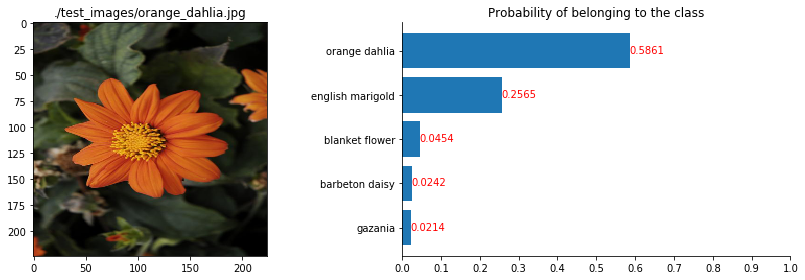

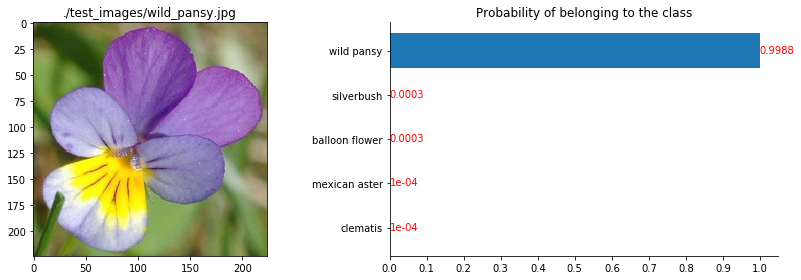

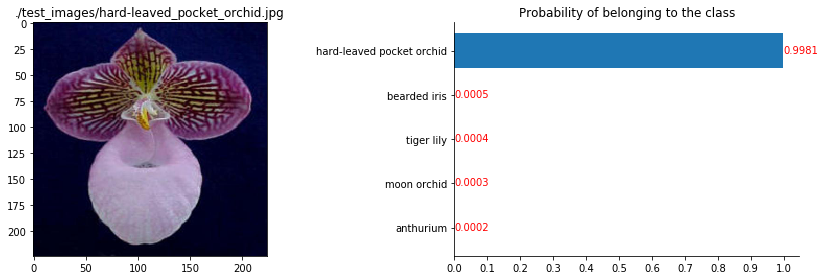

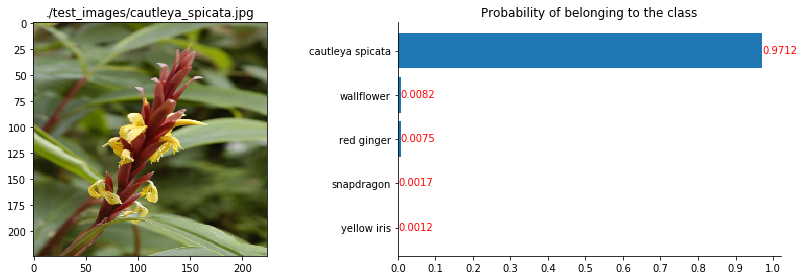

In [124]:
paths = glob.glob('./test_images/*.jpg')
print(paths)

for path in paths:
    im = Image.open(path)
    im_arr = np.asarray(im)
    processed_im = process_image(im_arr)
    probs, classes_label = predict(path, reloaded_keras_model, top_k)
    corrected_classes_label=[str(int(value)+1) for value in classes_label]
    classes_name = [class_names[label] for label in corrected_classes_label]
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    ax1.imshow(processed_im)
    ax1.set_title(path)
    ax2.barh(classes_name[::-1], probs[::-1])
    ax2.set_title('Probability of belonging to the class')
    ax2.set_xticks(np.arange(11)/10)
    ax2.set_xticklabels(np.arange(11)/10)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    for i, v in enumerate(probs[::-1]):
        ax2.text(v, i-0.05, str(round(v,4)), color='red')
    plt.tight_layout()
    plt.show()
